# Gradient Boosting Machines for Wine Price Predictions

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import RegexpTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Load data
wine = pd.read_csv('data/wine-reviews/winemag-data_first150k.csv', index_col=0, encoding="utf-8")
wine.dropna(subset=["price"], inplace=True)
wine.reset_index(inplace=True)
print wine.shape
wine.head()

(137235, 11)


,index,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
wine["description"][0]

u'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022\u20132030.'

# Feature Engineering

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


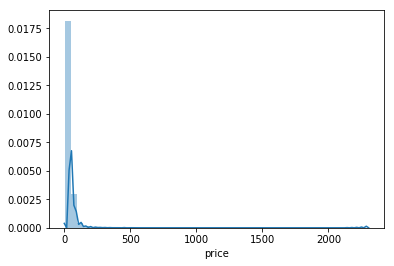

In [4]:
sns.distplot(wine.price)
plt.show()

In [5]:
def ohe_features(df, feature, occurances):
    '''
    df: pandas data frame with feature to be encoded
    feature: str. feature name
    occurances: number of occurances to threshold feature at
    '''
    vc = df[feature].value_counts()
    keep_values = vc[vc > occurances].index.tolist()
    ohe_feature = pd.get_dummies(df[feature])

    feature_names = ohe_feature.columns
    keep_features = feature_names[feature_names.isin(keep_values)]
    return ohe_feature[keep_features]

In [6]:
country = pd.get_dummies(wine.country)
collist = country.columns.tolist()
collist = ["country_" + s for s in collist]
country.columns = collist
print "There are {} country categorical variables".format(country.shape[1])

designation = ohe_features(wine, "designation", 50)
collist = designation.columns.tolist()
collist = ["designation_" + s for s in collist]
designation.columns = collist
print "There are {} designation categorical variables".format(designation.shape[1])

province = ohe_features(wine, "province", 50)
collist = province.columns.tolist()
collist = ["province_" + s for s in collist]
province.columns = collist
print "There are {} province categorical variables".format(province.shape[1])

region = ohe_features(wine, "region_1", 50)
collist = region.columns.tolist()
collist = ["region_" + s for s in collist]
region.columns = collist
print "There are {} region categorical variables".format(region.shape[1])

variety = ohe_features(wine, "variety", 50)
collist = variety.columns.tolist()
collist = ["variety_" + s for s in collist]
variety.columns = collist
print "There are {} variety categorical variables".format(variety.shape[1])

winery = ohe_features(wine, "winery", 50)
collist = winery.columns.tolist()
collist = ["winery_" + s for s in collist]
winery.columns = collist
print "There are {} winery categorical variables".format(winery.shape[1])

There are 46 country categorical variables
There are 71 designation categorical variables
There are 113 province categorical variables
There are 308 region categorical variables
There are 133 variety categorical variables
There are 454 winery categorical variables


In [7]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [8]:
wine["description"] = wine["description"].str.replace('\d+', '')
wine["description"] = wine.description.apply(func=remove_punctuation)
wine["description"] = wine.description.apply(func=make_lower_case)

In [17]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=100)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(wine.description)
lsa_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 100))
collist = ["description_" + s for s in collist]
lsa_features.columns = collist
lsa_features.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99
0,0.122660,-0.036983,-0.007284,-0.024192,-0.027222,0.005797,-0.037754,-0.007391,-0.046986,-0.003312,...,-0.010851,0.000029,-0.025451,0.001647,0.018548,0.006772,-0.012903,0.012492,0.013815,0.056843
1,0.135296,-0.041515,0.014830,-0.012616,0.012382,-0.090479,-0.006138,0.013664,0.038706,0.070568,...,-0.034556,0.010683,0.010840,-0.011940,-0.012811,0.025080,-0.004021,0.006161,0.016384,0.001695
2,0.077102,0.047119,-0.015741,-0.006972,0.012452,-0.025588,-0.018720,-0.029230,0.027470,-0.008500,...,0.044965,-0.038251,0.014865,0.008651,0.022634,0.014754,-0.011775,0.040749,-0.039756,0.007320
3,0.147136,-0.097177,0.031979,-0.001600,0.030316,-0.088576,-0.068348,-0.021176,-0.002156,0.008241,...,-0.052508,-0.008126,0.046214,0.006872,0.015693,-0.035708,-0.008703,-0.005419,0.020930,-0.004264
4,0.083745,0.001480,-0.080516,-0.100073,-0.024051,-0.010641,0.002331,-0.012737,-0.015761,-0.016869,...,0.006085,-0.019592,-0.011482,-0.035231,0.005624,0.020817,-0.019387,0.001939,0.021164,0.007946


In [19]:
X = pd.concat([country, designation, region, variety, winery, lsa_features, wine["points"]], sort=False, axis=1)
y = wine["price"]
print X.shape
print y.shape

(137235, 1113)
(137235,)


# Test Train Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3)

print "{} training observations".format(X_train.shape[0])
print "{} testing observations".format(X_test.shape[0])

96064 training observations
41171 testing observations


# XGBoost Classification

In [21]:
import xgboost as xgb

In [22]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [36]:
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [37]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-mae:14.4864	train-mae:14.5674
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-mae:14.2162	train-mae:14.2233
[2]	eval-mae:13.9898	train-mae:13.9837
[3]	eval-mae:13.668	train-mae:13.6292
[4]	eval-mae:13.5203	train-mae:13.46
[5]	eval-mae:13.49	train-mae:13.402
[6]	eval-mae:13.4591	train-mae:13.3308
[7]	eval-mae:13.3516	train-mae:13.2379
[8]	eval-mae:13.3529	train-mae:13.2312
[9]	eval-mae:13.2492	train-mae:13.1118


In [38]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
pred["prediction"] = np.round(pred["prediction"],0)
pred.sample(5)

,price,prediction
9512,23.0,33.0
59853,30.0,56.0
30328,44.0,58.0
67208,30.0,14.0
77550,45.0,70.0


In [41]:
from sklearn.metrics import median_absolute_error, mean_absolute_error
mean_ae = np.round(mean_absolute_error(y_true=pred["price"], y_pred=pred["prediction"]),2)
median_ae = np.round(median_absolute_error(y_true=pred["price"], y_pred=pred["prediction"]),2)
print "Mean Absolute Error: ${}".format(mean_ae)
print "Median Absolute Error: ${}".format(median_ae)

Mean Absolute Error: $13.25
Median Absolute Error: $8.0


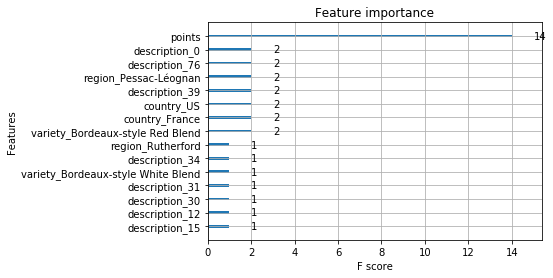

In [54]:
xgb.plot_importance(bst,max_num_features=15)

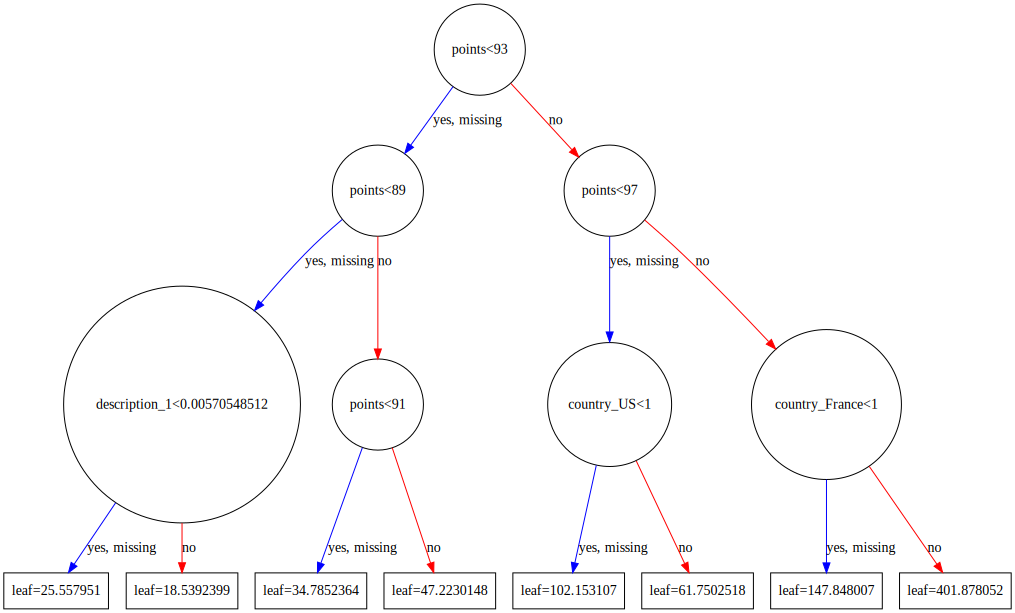

In [53]:
xgb.to_graphviz(bst, num_trees=0)